frequency format/natural frequencies - use counts rather than probabilities

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

In [2]:
p_grid = jnp.linspace(0, 1, 1000)
prob_p = jnp.repeat(1, 1000)

prob_data = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))

posterior = prob_data * prob_p
posterior = posterior / jnp.sum(posterior)

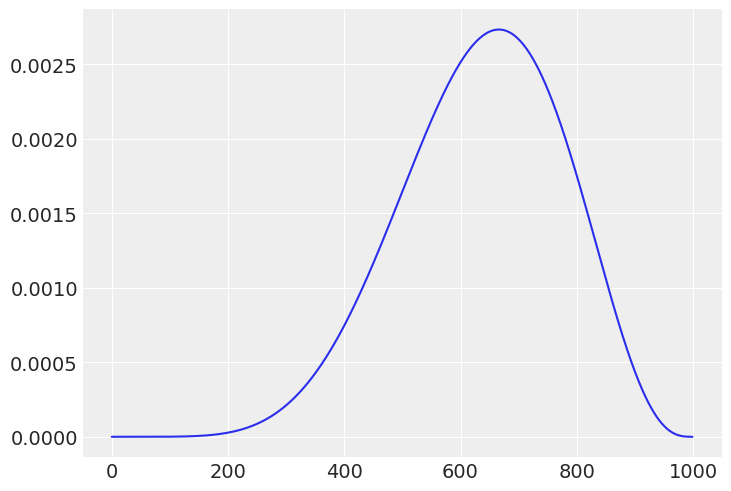

In [3]:
plt.plot(posterior)

In [4]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

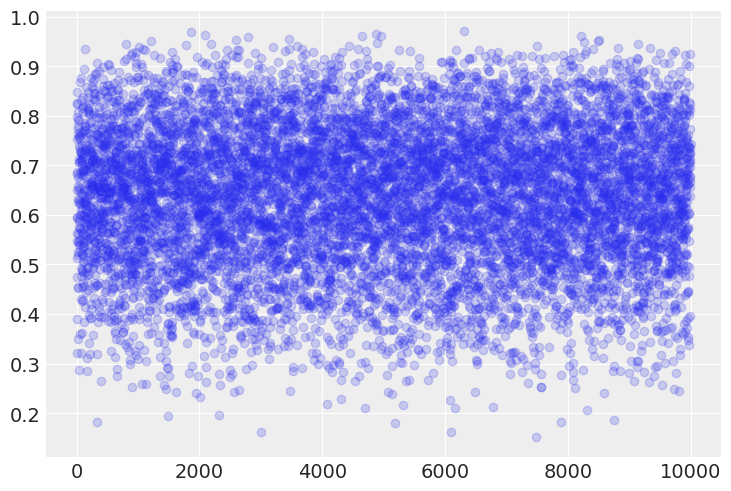

In [5]:
plt.scatter(range(len(samples)),samples, alpha=0.2)

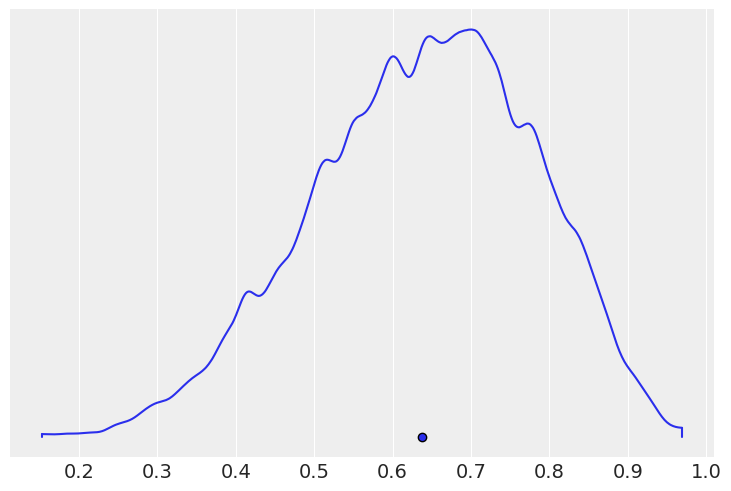

In [6]:
az.plot_density({"":samples},hdi_prob=1)
plt.show()

1. how much opsteriror prob below param
1. how mjch posterior between two param
1. which param makes 5% less posterior
1. which range contains 90% of posterior prob
1. which param has highest posteriro prob

In [7]:
sum(posterior[p_grid < 0.5])

0.1718745963345375

In [8]:
sum(samples < 0.5) / 1e4

0.1711

In [9]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6025

~Credible interval~ compatbility interval. 

It is interval that best compatible and describes th model and data

In [10]:
jnp.quantile(samples, 0.8)

DeviceArray(0.7637638, dtype=float32)

In [11]:
jnp.quantile(samples, jnp.array([.1, .9]))

DeviceArray([0.44644645, 0.8168168 ], dtype=float32)

Percentile Intervals - equal probability mass.



In [12]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(
    total_count=3,
    probs=p_grid
).log_prob(3))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)

In [13]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), 
(10000,))]

In [14]:
jnp.percentile(samples, q=(25, 75))

DeviceArray([0.7077077, 0.9319319], dtype=float32)

In [15]:
numpyro.diagnostics.hpdi(samples, prob=0.5)

array([0.8418418, 0.998999 ], dtype=float32)

Highest posterior density Interval - narrowest interval conatined the specified probabilty mass

HDPI - high density posterior interval
PI - percentile interval
They are only different for highly skewed distribution. 


HDPI disadvantage - it's must computational intensive than PI. greater simulation variance.

If the choise of interval type makes a difference, you shouldn't be using them to summarize the posterior. 



Meaning of compatibility intervals

- 95% confidence interval means there is a probabily of 95% that true paramter lies between the interval.

strict non-bayesain forbid using probabilty to measure un to measure uncertainty of paramters

we could say " if we repeat the study x number of times, 95% of the computed interval would contain the true paramter value.

bayesian interpretation: 
- 

In [16]:
p_grid[jnp.argmax(posterior)]

DeviceArray(1., dtype=float32)

In [17]:
samples[jnp.argmax(gaussian_kde(samples, bw_method=0.01)(samples))]

DeviceArray(0.988989, dtype=float32)

In [18]:
jnp.mean(samples)

DeviceArray(0.8011086, dtype=float32)

In [19]:
jnp.median(samples)

DeviceArray(0.8428428, dtype=float32)

In [20]:
jnp.sum(posterior *jnp.absolute(0.5 - p_grid))

DeviceArray(0.31287515, dtype=float32)

In [21]:
loss = vmap(lambda d: jnp.sum(posterior * jnp.abs(d-p_grid)))(p_grid)

In [22]:
p_grid[jnp.argmin(loss)]

DeviceArray(0.8408408, dtype=float32)

In [23]:
jnp.median(samples
)

DeviceArray(0.8428428, dtype=float32)

absolute loss leads you to median

quadratic loss leads you to mean

Model design - sample from prior
- see what the model expects before it arrives

model checking - worth simulating implifed observation

software validation - it helps ot simulate observation under known model. 

research design - if you can simulate observation from hypothesis, then you can evaluate whether reserah can be effective

forecasting - estimate can be used to make new predictions

Bayesian are always generative

$$
Let W = water \\

Let N = number of tosses \\

Pr(W|N, p) = \frac{N!}{W!(N-W)!}p^W(1-p)^{N-W}

In [24]:
# throw it 2 times, p = 0.7
jnp.exp(dist.Binomial(total_count=2,probs=0.7).log_prob(jnp.arange(3)))

DeviceArray([0.09000004, 0.42000008, 0.49000022], dtype=float32)

9% of w = 0, 42% for w =1, and 49% w = 2

In [25]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0))

DeviceArray(1, dtype=int32)

In [26]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (10,))

DeviceArray([2, 1, 2, 1, 1, 2, 2, 2, 2, 1], dtype=int32)

In [27]:
dummy_w = dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (100000,))

In [28]:
jnp.unique(dummy_w, return_counts=True)[1] /1e5

DeviceArray([0.09124, 0.42092, 0.48784], dtype=float32)

In [29]:
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.09124, 0.42092, 0.48784], dtype=float32)

In [30]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(
    random.PRNGKey(2), (100000,)
)

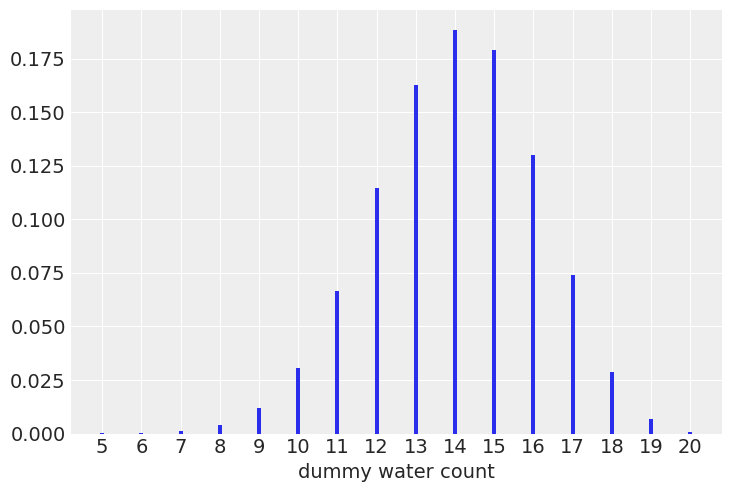

In [31]:
dummy_w = dist.Binomial(total_count=20, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

In [32]:
dist.Binomial(total_count=2, probs=.7).sample(
    random.PRNGKey(0), (10,)
)

Buffer([1, 1, 1, 2, 2, 1, 1, 2, 0, 1], dtype=int32)

In [33]:
dummy_w = dist.Binomial(total_count=2, probs=.7).sample(
    random.PRNGKey(0), (100000,)
)

In [34]:
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.0888 , 0.41789, 0.49331], dtype=float32)

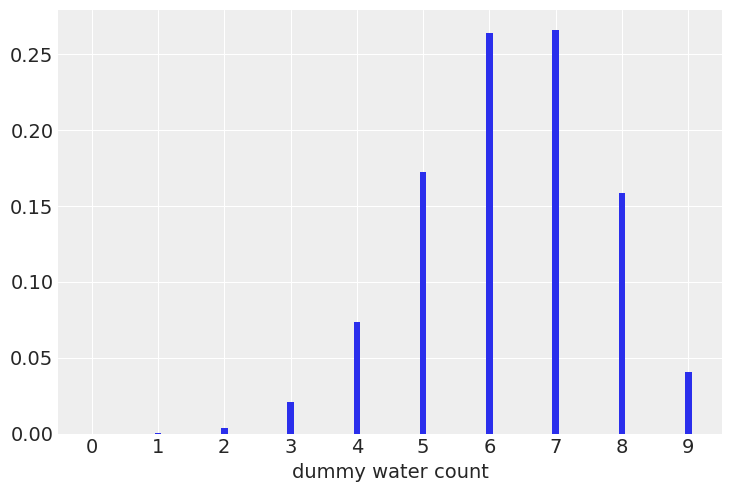

In [35]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

In [36]:
w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0))


Practice

In [46]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
#random.seed(100)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

In [61]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

In [76]:
jnp.sum(posterior[posterior<0.2]) / 1e4

DeviceArray(1.e-04, dtype=float32)

In [62]:
#3E1
jnp.sum(samples[samples < 0.2]) / 1e4

DeviceArray(0.00017918, dtype=float32)

In [63]:
#3E2
jnp.sum(samples[samples > 0.8]) / 1e4

DeviceArray(0.10273184, dtype=float32)

In [64]:
jnp.sum(samples[(samples < 0.8) & ( samples > 0.2)]) / 1e4

DeviceArray(0.5344119, dtype=float32)

In [68]:
# 3e4
jnp.quantile(samples, 0.2)

DeviceArray(0.5185185, dtype=float32)

In [67]:
# 3E5
jnp.quantile(samples, 0.8)

DeviceArray(0.7607608, dtype=float32)

In [69]:
# 3e6
numpyro.diagnostics.hpdi(samples, prob=0.66)

array([0.5155155, 0.7847848], dtype=float32)

In [72]:
# 3e7
jnp.percentile(samples, q=(17,83))

DeviceArray([0.5023324, 0.7737738], dtype=float32)

In [78]:
samples

DeviceArray([0.7247247, 0.6156156, 0.7437437, ..., 0.6116116, 0.6676677,
             0.5385385], dtype=float32)